<a href="https://colab.research.google.com/github/wstroks/DeepWstroks/blob/master/Machine%20Learning%20para%20Competi%C3%A7%C3%B5es%20Kaggle/KDD_Cup_2009.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudo de Caso: KDD Cup 2009

A Administração de Relacionamento com o Consumidor é um elemento-chave das estratégias modernas de marketing. A maneira mais prática de adquirir conhecimento sobre consumidores é produzindo pontuações. Uma pontuação é a saída de um modelo e serve como avaliação de todas as instâncias de uma variável-alvo que se pretenda explicar. Ferramentas que produzem pontuações permitem projetar informações quantificáveis em uma dada população. A pontuação é calculada usando variáveis de entrada que descrevem as instâncias. As pontuações são então usadas pelo sistema de informação, por exemplo, para personalizar o relacionamento com o consumidor.

Em 2009, a conferência Knowledge Discovery and Data Mining (KDD) lançou um desafio envolvendo aprendizagem de máquina. Ela disponibilizou dados de consumidores da empresa de telecomunicações francesa Orange, que deveriam ser utilizados para a construção de um modelo capaz de prever três comportamentos do consumidor. A planilha fornecida tem 50000 instâncias e 230 variáveis, sendo as primeiras 190 variáveis numéricas e as demais 40 categóricas. As variáveis de saída do modelo eram o cancelamento da conta ('churn'), a tendência de usar novos produtos e serviços ('appetency') e a propensão para comprar upgrades ou adicionais com maior margem de lucro quando apresentados (upselling), fornecidos de forma binária (-1 para *não*, 1 para *sim*).

O trabalho apresentado aqui envolve a criação de um modelo para predição de *churn*, *appetency* e *upselling* com base nos dados fornecidos dos clientes da Orange. O critério para avaliação do modelo será a métrica AUC, que dimensiona o trade-off entre taxa de falsos positivos e taxa de verdadeiros positivos: quanto mais próximo de 1, menor o trade-off e melhor o modelo.

Detalhes sobre a competição: https://www.kdd.org/kdd-cup/view/kdd-cup-2009

# Etapa 1: Modelando 'churn' (cancelamento da conta)

### Importando as dependências

In [0]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

### Carregando os dados

In [0]:
features = pd.read_csv('/content/orange_small_train.data', sep = '\t', na_filter = False)
outcome = pd.read_csv('/content/orange_small_train_churn.labels', header = None)

In [0]:
features.shape

(50000, 230)

In [0]:
features.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,,,,,,1526,7,,,,,,184,,,,,,,,464,580,,14,128,,,166.56,,,,,,,0,,,3570,,,...,,bZkvyxLkBI,RO12,,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,,,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,,uKAI,L84s,XfqtO3UdzaXh_,,,,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,,,xb3V,RAYp,F2FyR07IdsN7I,,
1,,,,,,525,0,,,,,,0,,,,,,,,168,210,,2,24,,,353.52,,,,,,,0,,,4764966,,,...,,CEat0G8rTN,RO12,,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,,,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,,uKAI,L84s,NhsEn4L,,,,kZJyVg2,,,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,,,fKCe,RAYp,F2FyR07IdsN7I,,
2,,,,,,5236,7,,,,,,904,,,,,,,,1212,1515,,26,816,,,220.08,,,,,,,0,,,5883894,,,...,,eOQt0GoOh3,AERks4l,SEuy,taul,1K8T,ffXs,NldASpP,y4g9XoZ,vynJTq9,smXZ,4bTR,9_Y1,MGOA,VpdQ,haYg,DHn_WUyBhW_whjA88g9bvA64_,kIsH,,uKAI,L84s,UbxQ8lZ,,TTGHfSv,,pMWAe2U,bHR7,UYBR,FzaX,JFM1BiF,Al6ZaUT,NKv4yOc,jySVZNlOJy,,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,
3,,,,,,,0,,,,,,0,,,,,,,,,0,,,0,,,22.08,,,,,,,0,,,0,,,...,,jg69tYsGvO,RO12,,taul,1K8T,ssAy,_ybO0dd,4hMlgkf58mhwh,,,W8mQ,9_Y1,YULl,VpdQ,,me75fM6ugJ,kIsH,,uKAI,Mtgm,NhsEn4L,,,,kq0dQfu,eKej,UYBR,FzaX,L91KIiz,oslk,CE7uk3u,LM8l689qOp,,,FSa2,RAYp,F2FyR07IdsN7I,,
4,,,,,,1029,7,,,,,,3216,,,,,,,,64,80,,4,64,,,200,,,,,,,0,,,0,,,...,,IXSgUHShse,RO12,SEuy,taul,1K8T,uNkU,EKR938I,ThrHXVS,0v21jmy,smXZ,xklU,9_Y1,RVjC,sJzTlal,6JmL,me75fM6ugJ,kIsH,,uKAI,L84s,XfqtO3UdzaXh_,,SJs3duv,,11p4mKe,H3p7,UYBR,FzaX,OrnLfvc,oslk,1J2cvxe,LM8l689qOp,,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,


In [0]:
outcome.head()

,0
0,-1
1,1
2,-1
3,-1
4,-1


In [0]:
np.unique(outcome)

array([-1,  1])

### Identificando as variáveis numéricas e categóricas

In [0]:
all_vars = np.array(features.columns)

In [0]:
all_vars

array(['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8',
       'Var9', 'Var10', 'Var11', 'Var12', 'Var13', 'Var14', 'Var15',
       'Var16', 'Var17', 'Var18', 'Var19', 'Var20', 'Var21', 'Var22',
       'Var23', 'Var24', 'Var25', 'Var26', 'Var27', 'Var28', 'Var29',
       'Var30', 'Var31', 'Var32', 'Var33', 'Var34', 'Var35', 'Var36',
       'Var37', 'Var38', 'Var39', 'Var40', 'Var41', 'Var42', 'Var43',
       'Var44', 'Var45', 'Var46', 'Var47', 'Var48', 'Var49', 'Var50',
       'Var51', 'Var52', 'Var53', 'Var54', 'Var55', 'Var56', 'Var57',
       'Var58', 'Var59', 'Var60', 'Var61', 'Var62', 'Var63', 'Var64',
       'Var65', 'Var66', 'Var67', 'Var68', 'Var69', 'Var70', 'Var71',
       'Var72', 'Var73', 'Var74', 'Var75', 'Var76', 'Var77', 'Var78',
       'Var79', 'Var80', 'Var81', 'Var82', 'Var83', 'Var84', 'Var85',
       'Var86', 'Var87', 'Var88', 'Var89', 'Var90', 'Var91', 'Var92',
       'Var93', 'Var94', 'Var95', 'Var96', 'Var97', 'Var98', 'Var99',
       'Var100', 'Va

In [0]:
num_vars = np.array(all_vars[:190])
num_vars

array(['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8',
       'Var9', 'Var10', 'Var11', 'Var12', 'Var13', 'Var14', 'Var15',
       'Var16', 'Var17', 'Var18', 'Var19', 'Var20', 'Var21', 'Var22',
       'Var23', 'Var24', 'Var25', 'Var26', 'Var27', 'Var28', 'Var29',
       'Var30', 'Var31', 'Var32', 'Var33', 'Var34', 'Var35', 'Var36',
       'Var37', 'Var38', 'Var39', 'Var40', 'Var41', 'Var42', 'Var43',
       'Var44', 'Var45', 'Var46', 'Var47', 'Var48', 'Var49', 'Var50',
       'Var51', 'Var52', 'Var53', 'Var54', 'Var55', 'Var56', 'Var57',
       'Var58', 'Var59', 'Var60', 'Var61', 'Var62', 'Var63', 'Var64',
       'Var65', 'Var66', 'Var67', 'Var68', 'Var69', 'Var70', 'Var71',
       'Var72', 'Var73', 'Var74', 'Var75', 'Var76', 'Var77', 'Var78',
       'Var79', 'Var80', 'Var81', 'Var82', 'Var83', 'Var84', 'Var85',
       'Var86', 'Var87', 'Var88', 'Var89', 'Var90', 'Var91', 'Var92',
       'Var93', 'Var94', 'Var95', 'Var96', 'Var97', 'Var98', 'Var99',
       'Var100', 'Va

In [0]:
cat_vars = np.array(all_vars[190:])
cat_vars

array(['Var191', 'Var192', 'Var193', 'Var194', 'Var195', 'Var196',
       'Var197', 'Var198', 'Var199', 'Var200', 'Var201', 'Var202',
       'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208',
       'Var209', 'Var210', 'Var211', 'Var212', 'Var213', 'Var214',
       'Var215', 'Var216', 'Var217', 'Var218', 'Var219', 'Var220',
       'Var221', 'Var222', 'Var223', 'Var224', 'Var225', 'Var226',
       'Var227', 'Var228', 'Var229', 'Var230'], dtype=object)

### Verificando a consistência das variáveis

In [0]:
features.dtypes

Var1      object
Var2      object
Var3      object
Var4      object
Var5      object
           ...  
Var226    object
Var227    object
Var228    object
Var229    object
Var230    object
Length: 230, dtype: object

In [0]:
var = features.groupby('Var1').size()
var

Var1
       49298
0        380
120        1
128        2
152        1
16        81
24        46
32        23
360        1
392        1
40        10
48         6
536        1
56         5
64         1
680        1
72         3
8        138
80         1
dtype: int64

In [0]:
counts_per_column = pd.DataFrame()
for col in num_vars:
  col_count = features.groupby(col).size()
  counts_per_column = counts_per_column.append(col_count, ignore_index = True)

In [0]:
counts_per_column.shape

(190, 351788)

In [0]:
counts_per_column.head()

,,0,120,128,152,16,24,32,360,392,40,48,536,56,64,680,72,8,80,5,102,105,10617,108,1083,111,1113,114,1155,117,12,123,1242,126,12633,129,12927,130668,1332,1344,...,6651.18,67723.29,6893.82,69126.48,69166.71,693.45,693.99,7.47,7030.17,70445.25,7135.65,72177.84,73467.99,7584.66,7597.979,76999.23,77.67,78230.79,7922.7,79562.08,8022.96,81838.62,82165.95,8328.149,843.57,8573.939,8615.25,8660.25,86645.08,87838.47,8900.46,920.88,9336.06,9379.709,9441.36,9607.05,966.15,9772.021,98.1,9857.88
0,49298.0,380.0,1.0,2.0,1.0,81.0,46.0,23.0,1.0,1.0,10.0,6.0,1.0,5.0,1.0,1.0,3.0,138.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,48759.0,1240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48760.0,996.0,3.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,48421.0,1561.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,48513.0,898.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
counts_per_column.T.shape

(351788, 190)

In [0]:
counts_per_column.T.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189
,49298.0,48759.0,48760.0,48421.0,48513.0,5529.0,5539.0,50000.0,49298.0,48513.0,48760.0,49442.0,5539.0,48760.0,50000.0,48513.0,48421.0,48421.0,48421.0,50000.0,5529.0,5009.0,48513.0,7230.0,5009.0,48513.0,48513.0,5011.0,49298.0,49298.0,50000.0,50000.0,49153.0,48759.0,5009.0,48759.0,48421.0,5009.0,50000.0,48759.0,...,49153.0,48421.0,5009.0,49298.0,48421.0,49306.0,48871.0,49127.0,48759.0,5009.0,48421.0,48759.0,5009.0,48421.0,49127.0,48513.0,50000.0,49298.0,50000.0,48759.0,48917.0,48513.0,5009.0,48421.0,50000.0,48760.0,48759.0,49354.0,48421.0,49298.0,5009.0,48421.0,48759.0,48759.0,50000.0,49298.0,49298.0,48759.0,28978.0,49667.0
0,380.0,1240.0,996.0,1561.0,898.0,976.0,13090.0,NaN,144.0,902.0,NaN,304.0,12258.0,1154.0,NaN,54.0,939.0,1200.0,1543.0,NaN,1815.0,2221.0,1052.0,16205.0,6629.0,1457.0,1467.0,388.0,694.0,195.0,NaN,NaN,523.0,1126.0,41219.0,692.0,964.0,9405.0,NaN,830.0,...,523.0,475.0,2221.0,273.0,1430.0,142.0,418.0,650.0,939.0,3848.0,1266.0,747.0,13457.0,1296.0,650.0,898.0,NaN,4.0,NaN,892.0,290.0,391.0,44857.0,964.0,NaN,1083.0,771.0,174.0,1289.0,144.0,41990.0,706.0,830.0,771.0,NaN,525.0,240.0,44.0,NaN,4.0
120,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,134.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,959.0,296.0,1.0,NaN,762.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,2.0,...,2.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,56.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.0,NaN
128,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1680.0,NaN,NaN,NaN,703.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,124.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,968.0,NaN,NaN,1.0,664.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
counts_per_column = counts_per_column.T
counts_per_column.index = counts_per_column.index.astype('str')
counts_per_column.sort_index(inplace = True)
print('Primeiras dez categorias: ', counts_per_column.index[:10])
print('Últimas dez categorias: ', counts_per_column.index[(len(counts_per_column.index)-10):])

Primeiras dez categorias:  Index(['', '-10', '-1000060.0', '-10002.16', '-100034.8', '-1000420.0',
       '-1000468.0', '-1000496.0', '-1000516.0', '-1000548.0'],
      dtype='object')
Últimas dez categorias:  Index(['9999040', '999920', '9999240', '99993', '9999400', '9999440',
       '9999480', '99995', '99996', '999971'],
      dtype='object')


In [0]:
counts_per_column = pd.DataFrame()
for col in cat_vars:
  col_count = features.groupby(col).size()
  counts_per_column = counts_per_column.append(col_count, ignore_index = True)

In [0]:
counts_per_column = counts_per_column.T
counts_per_column.index = counts_per_column.index.astype('str')
counts_per_column.sort_index(inplace = True)
print('Primeiras dez categorias: ', counts_per_column.index[:10])
print('Últimas dez categorias: ', counts_per_column.index[(len(counts_per_column.index)-10):])

Primeiras dez categorias:  Index(['', '000J', '0062', '00AD', '00ARusu', '00AYONy', '00AhP4J', '00J8E9a',
       '00JHTSP', '00L3'],
      dtype='object')
Últimas dez categorias:  Index(['zzQ9udm', 'zzQV', 'zzbGOGx', 'zzbGa54', 'zzcv6yg4s3UGv', 'zzfHvGh',
       'zzfLM_S', 'zzfUfAI', 'zzfo6HG', 'zzpZ'],
      dtype='object')


In [0]:
features = features.replace('', np.nan)

In [0]:
features.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526,7,NaN,NaN,NaN,NaN,NaN,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,464,580,NaN,14,128,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,3570,NaN,NaN,...,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,NaN,NaN,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,NaN,NaN,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168,210,NaN,2,24,NaN,NaN,353.52,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,4764966,NaN,NaN,...,NaN,CEat0G8rTN,RO12,NaN,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,NaN,NaN,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,NaN,NaN,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236,7,NaN,NaN,NaN,NaN,NaN,904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1212,1515,NaN,26,816,NaN,NaN,220.08,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,5883894,NaN,NaN,...,NaN,eOQt0GoOh3,AERks4l,SEuy,taul,1K8T,ffXs,NldASpP,y4g9XoZ,vynJTq9,smXZ,4bTR,9_Y1,MGOA,VpdQ,haYg,DHn_WUyBhW_whjA88g9bvA64_,kIsH,NaN,uKAI,L84s,UbxQ8lZ,NaN,TTGHfSv,NaN,pMWAe2U,bHR7,UYBR,FzaX,JFM1BiF,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN,22.08,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,NaN,jg69tYsGvO,RO12,NaN,taul,1K8T,ssAy,_ybO0dd,4hMlgkf58mhwh,NaN,NaN,W8mQ,9_Y1,YULl,VpdQ,NaN,me75fM6ugJ,kIsH,NaN,uKAI,Mtgm,NhsEn4L,NaN,NaN,NaN,kq0dQfu,eKej,UYBR,FzaX,L91KIiz,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029,7,NaN,NaN,NaN,NaN,NaN,3216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64,80,NaN,4,64,NaN,NaN,200,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN,...,NaN,IXSgUHShse,RO12,SEuy,taul,1K8T,uNkU,EKR938I,ThrHXVS,0v21jmy,smXZ,xklU,9_Y1,RVjC,sJzTlal,6JmL,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,SJs3duv,NaN,11p4mKe,H3p7,UYBR,FzaX,OrnLfvc,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [0]:
for col in num_vars:
  features[col] = features[col].astype('float')
for col in cat_vars:
  features[col] = features[col].astype('category')

In [0]:
features.dtypes

Var1       float64
Var2       float64
Var3       float64
Var4       float64
Var5       float64
            ...   
Var226    category
Var227    category
Var228    category
Var229    category
Var230    category
Length: 230, dtype: object

### Seleção de variáveis

#### Variáveis com muitos valores faltantes


In [0]:
features.isna()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,True,True,True,True,True,False,False,True,True,True,True,True,False,True,True,True,True,True,True,True,False,False,True,False,False,True,True,False,True,True,True,True,True,True,False,True,True,False,True,True,...,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True
1,True,True,True,True,True,False,False,True,True,True,True,True,False,True,True,True,True,True,True,True,False,False,True,False,False,True,True,False,True,True,True,True,True,True,False,True,True,False,True,True,...,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,True,True,True,False,True,True,False,False,False,False,False,True,True,False,False,False,True,True
2,True,True,True,True,True,False,False,True,True,True,True,True,False,True,True,True,True,True,True,True,False,False,True,False,False,True,True,False,True,True,True,True,True,True,False,True,True,False,True,True,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
3,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,True,True,False,True,True,False,True,True,True,True,True,True,False,True,True,False,True,True,...,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True
4,True,True,True,True,True,False,False,True,True,True,True,True,False,True,True,True,True,True,True,True,False,False,True,False,False,True,True,False,True,True,True,True,True,True,False,True,True,False,True,True,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,True,True,True,True,True,False,False,True,True,True,True,True,False,True,True,True,True,True,True,True,False,False,True,False,False,True,True,False,True,True,True,True,True,True,False,True,True,False,True,True,...,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,True,True,True,False,False,False,False,False,False,False,False,True,True,False,False,False,True,True
49996,True,True,True,True,True,False,False,True,True,True,True,True,False,True,True,True,True,True,True,True,False,False,True,False,False,True,True,False,True,True,True,True,True,True,False,True,True,False,True,True,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
49997,True,True,True,True,Tr

In [0]:
empty_entries_per_column = features.isna().sum(axis = 0)

In [0]:
empty_entries_per_column

Var1      49298
Var2      48759
Var3      48760
Var4      48421
Var5      48513
          ...  
Var226        0
Var227        0
Var228        0
Var229    28432
Var230    50000
Length: 230, dtype: int64

48513.0


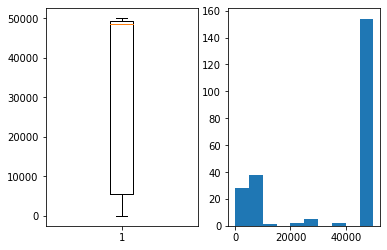

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.boxplot(empty_entries_per_column)
ax2.hist(empty_entries_per_column)
median = empty_entries_per_column.median()
print(median)

In [0]:
num_entries = len(features)
threshold = 0.25
num_entries * threshold

12500.0

In [0]:
keep_vars = np.array(features.columns[(empty_entries_per_column <= (num_entries * threshold))])

In [0]:
keep_vars

array(['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25',
       'Var28', 'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var73',
       'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var109',
       'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var132',
       'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var149',
       'Var153', 'Var160', 'Var163', 'Var173', 'Var181', 'Var192',
       'Var193', 'Var195', 'Var196', 'Var197', 'Var198', 'Var199',
       'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207',
       'Var208', 'Var210', 'Var211', 'Var212', 'Var216', 'Var217',
       'Var218', 'Var219', 'Var220', 'Var221', 'Var222', 'Var223',
       'Var226', 'Var227', 'Var228'], dtype=object)

In [0]:
num_vars = [elem for elem in num_vars if elem in keep_vars]
cat_vars = [elem for elem in cat_vars if elem in keep_vars]

In [0]:
len(num_vars)

38

In [0]:
len(cat_vars)

28

In [0]:
for col in num_vars:
  col_mean = features[col].mean()
  features[col] = features[col].fillna(col_mean)

In [0]:
for col in cat_vars:
  features[col] = features[col].cat.add_categories('missing')
  features[col] = features[col].fillna('missing')

In [0]:
features.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.000000,7.0,NaN,NaN,NaN,NaN,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,464.000000,580.0,NaN,14.000000,128.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3570.0,NaN,NaN,...,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,NaN,NaN,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,NaN,NaN,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.000000,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.000000,210.0,NaN,2.000000,24.0,NaN,NaN,353.52,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4764966.0,NaN,NaN,...,NaN,CEat0G8rTN,RO12,NaN,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,NaN,NaN,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,missing,missing,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.000000,7.0,NaN,NaN,NaN,NaN,NaN,904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1212.000000,1515.0,NaN,26.000000,816.0,NaN,NaN,220.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,5883894.0,NaN,NaN,...,NaN,eOQt0GoOh3,AERks4l,SEuy,taul,1K8T,ffXs,NldASpP,y4g9XoZ,vynJTq9,smXZ,4bTR,9_Y1,MGOA,VpdQ,haYg,DHn_WUyBhW_whjA88g9bvA64_,kIsH,NaN,uKAI,L84s,UbxQ8lZ,NaN,TTGHfSv,NaN,pMWAe2U,bHR7,UYBR,FzaX,JFM1BiF,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,1326.437116,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,234.518225,0.0,NaN,4.507926,0.0,NaN,NaN,22.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,jg69tYsGvO,RO12,NaN,taul,1K8T,ssAy,_ybO0dd,4hMlgkf58mhwh,NaN,NaN,W8mQ,9_Y1,YULl,VpdQ,missing,me75fM6ugJ,kIsH,NaN,uKAI,Mtgm,NhsEn4L,NaN,NaN,NaN,kq0dQfu,eKej,UYBR,FzaX,L91KIiz,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.000000,7.0,NaN,NaN,NaN,NaN,NaN,3216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.000000,80.0,NaN,4.000000,64.0,NaN,NaN,200.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,IXSgUHShse,RO12,SEuy,taul,1K8T,uNkU,EKR938I,ThrHXVS,0v21jmy,smXZ,xklU,9_Y1,RVjC,sJzTlal,6JmL,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,SJs3duv,NaN,11p4mKe,H3p7,UYBR,FzaX,OrnLfvc,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


#### Variáveis categóricas com muitas categorias

In [0]:
n_categories_per_feature = features[cat_vars].apply(lambda x: len(set(x)))

In [0]:
n_categories_per_feature

Var192      362
Var193       51
Var195       23
Var196        4
Var197      226
Var198     4291
Var199     5074
Var202     5714
Var203        6
Var204      100
Var205        4
Var206       22
Var207       14
Var208        3
Var210        6
Var211        2
Var212       81
Var216     2016
Var217    13991
Var218        3
Var219       23
Var220     4291
Var221        7
Var222     4291
Var223        5
Var226       23
Var227        7
Var228       30
dtype: int64

(array([21.,  1.,  0.,  4.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([2.00000e+00, 1.40090e+03, 2.79980e+03, 4.19870e+03, 5.59760e+03,
        6.99650e+03, 8.39540e+03, 9.79430e+03, 1.11932e+04, 1.25921e+04,
        1.39910e+04]),
 <a list of 10 Patch objects>)

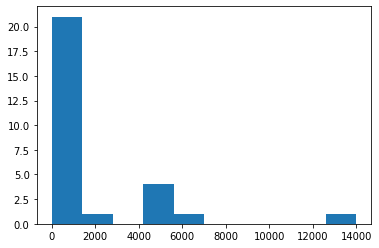

In [0]:
plt.hist(n_categories_per_feature)

In [0]:
cat_vars = np.array(n_categories_per_feature[n_categories_per_feature < 1400].index)

In [0]:
cat_vars

array(['Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var203',
       'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210',
       'Var211', 'Var212', 'Var218', 'Var219', 'Var221', 'Var223',
       'Var226', 'Var227', 'Var228'], dtype=object)

In [0]:
len(cat_vars)

21

In [0]:
list(cat_vars)

['Var192',
 'Var193',
 'Var195',
 'Var196',
 'Var197',
 'Var203',
 'Var204',
 'Var205',
 'Var206',
 'Var207',
 'Var208',
 'Var210',
 'Var211',
 'Var212',
 'Var218',
 'Var219',
 'Var221',
 'Var223',
 'Var226',
 'Var227',
 'Var228']

In [0]:
features = features[list(num_vars) + list(cat_vars)]

In [0]:
features.shape

(50000, 59)

In [0]:
features.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var44,Var57,Var65,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var109,Var112,Var113,Var119,Var123,Var125,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,Var192,Var193,Var195,Var196,Var197,Var203,Var204,Var205,Var206,Var207,Var208,Var210,Var211,Var212,Var218,Var219,Var221,Var223,Var226,Var227,Var228
0,1526.000000,7.0,184.0,464.000000,580.0,14.000000,128.0,166.56,0.0,3570.0,0.0,4.076907,9.0,36.0,35.0,1350864.0,0.0,7333.110000,5.0,12.0,104.00000,168.0,117625.60,1175.000000,6.0,720.0,0.0,1212385.0,69134.0,185.0,0.0,9.000000,397579.000000,1812252.0,142.0,38418.0,0.0,0.0,bZkvyxLkBI,RO12,taul,1K8T,lK27,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,uKAI,L84s,XfqtO3UdzaXh_,cJvF,FzaX,oslk,jySVZNlOJy,xb3V,RAYp,F2FyR07IdsN7I
1,525.000000,0.0,0.0,168.000000,210.0,2.000000,24.0,353.52,0.0,4764966.0,0.0,5.408032,9.0,26.0,0.0,2872928.0,3.0,151098.900000,25.0,2.0,40.00000,40.0,-356411.60,590.000000,72.0,0.0,8.0,4136430.0,357038.0,0.0,0.0,9.000000,278334.000000,10439160.0,32.0,238572.0,0.0,0.0,CEat0G8rTN,RO12,taul,1K8T,2Ix5,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,uKAI,L84s,NhsEn4L,missing,FzaX,oslk,LM8l689qOp,fKCe,RAYp,F2FyR07IdsN7I
2,5236.000000,7.0,904.0,1212.000000,1515.0,26.000000,816.0,220.08,0.0,5883894.0,0.0,6.599658,9.0,130.0,518.0,1675776.0,0.0,16211.580000,40.0,58.0,312.00000,336.0,405104.00,3230.000000,114.0,5967.0,0.0,3478905.0,248932.0,800.0,0.0,36.000000,320565.000000,9826360.0,206.0,434946.0,0.0,0.0,eOQt0GoOh3,AERks4l,taul,1K8T,ffXs,9_Y1,MGOA,VpdQ,haYg,DHn_WUyBhW_whjA88g9bvA64_,kIsH,uKAI,L84s,UbxQ8lZ,UYBR,FzaX,Al6ZaUT,jySVZNlOJy,Qu4f,02N6s8f,ib5G6X1eUxUn6
3,1326.437116,0.0,0.0,234.518225,0.0,4.507926,0.0,22.08,0.0,0.0,0.0,1.988250,9.0,12.0,0.0,0.0,0.0,103084.052693,0.0,0.0,60.88866,0.0,-275703.60,916.112185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.727665,294920.804255,0.0,0.0,0.0,0.0,0.0,jg69tYsGvO,RO12,taul,1K8T,ssAy,9_Y1,YULl,VpdQ,missing,me75fM6ugJ,kIsH,uKAI,Mtgm,NhsEn4L,UYBR,FzaX,oslk,LM8l689qOp,FSa2,RAYp,F2FyR07IdsN7I
4,1029.000000,7.0,3216.0,64.000000,80.0,4.000000,64.0,200.00,0.0,0.0,0.0,4.552446,18.0,82.0,224.0,784448.0,0.0,37423.500000,0.0,0.0,32.00000,56.0,10714.84,215.000000,0.0,15111.0,0.0,150650.0,66046.0,3255.0,0.0,9.000000,267162.000000,644836.0,2.0,0.0,0.0,0.0,IXSgUHShse,RO12,taul,1K8T,uNkU,9_Y1,RVjC,sJzTlal,6JmL,me75fM6ugJ,kIsH,uKAI,L84s,XfqtO3UdzaXh_,UYBR,FzaX,oslk,LM8l689qOp,FSa2,RAYp,F2FyR07IdsN7I


#### Seleção de variáveis baseada em árvore de decisão

Seleção de atributos: https://scikit-learn.org/stable/modules/feature_selection.html

1 - Palio
2 - Gol
3 - Uno

Palio - 1 0 0
Gol - 0 1 0
Uno - 0 1 1

In [0]:
features_c = pd.get_dummies(features)

In [0]:
features_c.shape

(50000, 1052)

In [0]:
features_c.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var44,Var57,Var65,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var109,Var112,Var113,Var119,Var123,Var125,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,Var192_0G9vyxdMWg,Var192_0kQTmBU3gb,...,Var226_missing,Var227_02N6s8f,Var227_6fzt,Var227_RAYp,Var227_ZI9m,Var227_nIGXDli,Var227_nIGjgSB,Var227_vJ_w8kB,Var227_missing,Var228_0pzBWGkV3fbsGZN52DH,Var228_4rd_,Var228_55YFVY9,Var228_5oZS,Var228_6nxx00q6gnIF8ePJ3P3AEfZ1N,Var228_9VmiOykV3fbsAg65e4w,Var228_DU8B,Var228_F2FcTt7IdMT_v,Var228_F2FyR07IdsN7I,Var228_JnGLH58smNxIYcGK39k,Var228_NoEd,Var228_R4y5gQQWY8OodqDV,Var228_RjBDiL8f9CQYc21fICscNNpj6,Var228_SbOd7O8ky1wGNxp0Arj0Xs,Var228_TCU50_Yjmm6GIBZ0lL_,Var228_VjDE,Var228_WfJ2BB2SFSqauljlfOB,Var228_WfJYmPMksSqa1pajvfG,Var228_ZeaF,Var228_Zy3gnGM,Var228__URKn_77G3QyQHSVQ2N1RKmtW,Var228__cTCyH95OE93jSkoIBT,Var228_am14IcfM7tWLrUmRT52KtA,Var228_b9qbUNk0dML_Mvi2,Var228_d0LtHjWeaXyArdN4sxU_saXqH,Var228_ib5G6X1eUxUn6,Var228_iyHGyLCEkQ,Var228_n1OBWGkV3fbsHR75taC,Var228_r_7E,Var228_xwM2aC7IdeMC0,Var228_missing
0,1526.000000,7.0,184.0,464.000000,580.0,14.000000,128.0,166.56,0.0,3570.0,0.0,4.076907,9.0,36.0,35.0,1350864.0,0.0,7333.110000,5.0,12.0,104.00000,168.0,117625.60,1175.000000,6.0,720.0,0.0,1212385.0,69134.0,185.0,0.0,9.000000,397579.000000,1812252.0,142.0,38418.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,525.000000,0.0,0.0,168.000000,210.0,2.000000,24.0,353.52,0.0,4764966.0,0.0,5.408032,9.0,26.0,0.0,2872928.0,3.0,151098.900000,25.0,2.0,40.00000,40.0,-356411.60,590.000000,72.0,0.0,8.0,4136430.0,357038.0,0.0,0.0,9.000000,278334.000000,10439160.0,32.0,238572.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5236.000000,7.0,904.0,1212.000000,1515.0,26.000000,816.0,220.08,0.0,5883894.0,0.0,6.599658,9.0,130.0,518.0,1675776.0,0.0,16211.580000,40.0,58.0,312.00000,336.0,405104.00,3230.000000,114.0,5967.0,0.0,3478905.0,248932.0,800.0,0.0,36.000000,320565.000000,9826360.0,206.0,434946.0,0.0,0.0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1326.437116,0.0,0.0,234.518225,0.0,4.507926,0.0,22.08,0.0,0.0,0.0,1.988250,9.0,12.0,0.0,0.0,0.0,103084.052693,0.0,0.0,60.88866,0.0,-275703.60,916.112185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.727665,294920.804255,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1029.000000,7.0,3216.0,64.000000,80.0,4.000000,64.0,200.00,0.0,0.0,0.0,4.552446,18.0,82.0,224.0,784448.0,0.0,37423.500000,0.0,0.0,32.00000,56.0,10714.84,215.000000,0.0,15111.0,0.0,150650.0,66046.0,3255.0,0.0,9.000000,267162.000000,644836.0,2.0,0.0,0.0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Random Forest x Extra Tree: https://www.thekerneltrip.com/statistics/random-forest-vs-extra-tree/

In [0]:
np.array(outcome).ravel()

array([-1,  1, -1, ..., -1, -1, -1])

In [0]:
def etc_importances(features, outcome):
  model = ExtraTreesClassifier(n_estimators = 200, criterion = 'entropy', verbose = 0)
  model.fit(features, np.array(outcome).ravel())
  
  importances = model.feature_importances_
  variables = np.array(features.columns)
  indices = np.argsort(importances)[::-1]
  importances = importances[indices]
  variables = variables[indices]
  
  return variables, importances

In [0]:
variables, importances = etc_importances(features_c, outcome)

In [0]:
importances

array([0.01819073, 0.01760868, 0.01726286, ..., 0.        , 0.        ,
       0.        ])

In [0]:
variables

array(['Var57', 'Var73', 'Var113', ..., 'Var212_missing',
       'Var219_6krWwfF', 'Var228_missing'], dtype=object)

In [0]:
variables[0]

'Var57'

In [0]:
importances[0]

0.018190734346165905

In [0]:
variables[1051]

'Var228_missing'

In [0]:
importances[1051]

0.0

In [0]:
def sum_and_plot_importances(variables, importances):
  sum_importances = pd.DataFrame()
  for i in range(importances.size):
    sum_importance = importances[:(i+1)].sum()
    this_variable = pd.Series([variables[i], sum_importance])
    sum_importances = sum_importances.append(this_variable, ignore_index = True)
  plt.scatter(sum_importances.index, sum_importances.iloc[:,1])
  return sum_importances

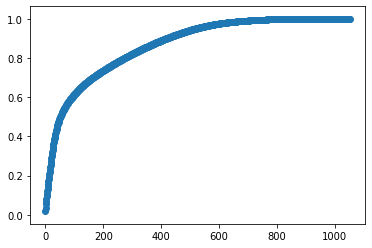

In [0]:
sum_importances = sum_and_plot_importances(variables, importances)

In [0]:
sum_importances

,0,1
0,Var57,0.018191
1,Var73,0.035799
2,Var113,0.053062
3,Var153,0.066772
4,Var81,0.080410
...,...,...
1047,Var197_bkoB,1.000000
1048,Var197_AuRO,1.000000
1049,Var212_missing,1.000000
1050,Var219_6krWwfF,1.000000


In [0]:
def keep_vars(features, sum_importances, threshold):
  keep_vars = list(sum_importances[sum_importances.iloc[:, 1] <= threshold].iloc[:, 0])
  features = features.loc[:, keep_vars]
  
  return features

In [0]:
features_c = keep_vars(features_c, sum_importances, threshold = 0.99)

In [0]:
features_c.shape

(50000, 685)

In [0]:
features_c.head()

,Var57,Var73,Var113,Var153,Var81,Var133,Var134,Var38,Var76,Var28,Var6,Var25,Var119,Var22,Var123,Var163,Var160,Var21,Var112,Var149,Var83,Var109,Var85,Var125,Var24,Var13,Var144,Var140,Var7,Var65,Var74,Var205_VpdQ,Var223_LM8l689qOp,Var205_sJzTlal,Var205_09_Q,Var218_missing,Var132,Var218_cJvF,Var206_IYzP,Var219_FzaX,...,Var192_AKDr4RXktW,Var192_NFqq9at_88,Var197_NbV4,Var197_L_LK,Var212_MeOIHRG3F9,Var192_7Cwt0Gdc_a,Var192_H7er4Rdc_a,Var195_I9xt3GMcxUnBZ,Var207_0MCPoln,Var212_4ylQpLr46xum2hHQ,Var207_5iay,Var192_IXSt0GoOh3,Var192_Yddr4R4FLE,Var197_nCqp,Var212_QsQAxv5,Var197_W5sH,Var192_86ct0Gdncc,Var197_plfw,Var219_FqMWi1g,Var193_NRCqczK,Var195_ev6I,Var197_z8at,Var192_dPsBcmRZ57,Var212_TVE1uh4F_wOi_,Var197_EbEb,Var212_6z7lZp6XhQkon,Var192_l0JOj17ejg,Var192_xOXTmBkF1Q,Var212_fnfcPDe,Var193_LrdVolaSGUfkVeWC,Var192_zKnrjIPxRp,Var228_DU8B,Var192_bZkPe2fHUn,Var193_X2uI6IsGev,Var204_7JiV,Var197_gEzH,Var228_d0LtHjWeaXyArdN4sxU_saXqH,Var195_bsZtYxFjzA,Var192_9u0r4Rdncc,Var195_TnJpfvsJgF
0,4.076907,36.0,117625.60,1812252.0,7333.110000,1212385.0,69134.0,3570.0,1350864.0,166.56,1526.000000,128.0,1175.000000,580.0,6.0,38418.0,142.0,464.000000,168.0,397579.000000,5.0,104.00000,12.0,720.0,14.000000,184.0,9.000000,185.0,7.0,9.0,35.0,1,0,0,0,0,0.0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5.408032,26.0,-356411.60,10439160.0,151098.900000,4136430.0,357038.0,4764966.0,2872928.0,353.52,525.000000,24.0,590.000000,210.0,72.0,238572.0,32.0,168.000000,40.0,278334.000000,25.0,40.00000,2.0,0.0,2.000000,0.0,9.000000,0.0,0.0,9.0,0.0,0,1,1,0,1,8.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6.599658,130.0,405104.00,9826360.0,16211.580000,3478905.0,248932.0,5883894.0,1675776.0,220.08,5236.000000,816.0,3230.000000,1515.0,114.0,434946.0,206.0,1212.000000,336.0,320565.000000,40.0,312.00000,58.0,5967.0,26.000000,904.0,36.000000,800.0,7.0,9.0,518.0,1,0,0,0,0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.988250,12.0,-275703.60,0.0,103084.052693,0.0,0.0,0.0,0.0,22.08,1326.437116,0.0,916.112185,0.0,0.0,0.0,0.0,234.518225,0.0,294920.804255,0.0,60.88866,0.0,0.0,4.507926,0.0,11.727665,0.0,0.0,9.0,0.0,1,1,0,0,0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.552446,82.0,10714.84,644836.0,37423.500000,150650.0,66046.0,0.0,784448.0,200.00,1029.000000,64.0,215.000000,80.0,0.0,0.0,2.0,64.000000,56.0,267162.000000,0.0,32.00000,0.0,15111.0,4.000000,3216.0,9.000000,3255.0,7.0,18.0,224.0,0,1,1,0,0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Dividindo os dados em dataset para treino e dataset para teste

In [0]:
def split_datasets(features, outcome, test_size = 0.2):
  X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size = test_size,
                                                      stratify = outcome, random_state = 0)
  y_train, y_test = np.array(y_train).ravel(), np.array(y_test).ravel()
  
  return X_train, X_test, y_train, y_test

In [0]:
X_train, X_test, y_train, y_test = split_datasets(features_c, outcome)

In [0]:
X_train.shape

(40000, 685)

In [0]:
X_test.shape

(10000, 685)

### Modelagem preliminar

AUC e ROC: https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772

#### Random Forest Classifier

In [0]:
def rfc_test(X_train, y_train, n_estimators = 100, cv = 5):
  np.random.seed(0)
  rfc = RandomForestClassifier(n_estimators = n_estimators, random_state = 0, n_jobs = -1)
  cv_scores = cross_val_score(rfc, X_train, y_train, scoring = 'roc_auc', cv = cv, n_jobs = -1)
  print('Média dos cinco testes: ', cv_scores.mean())

In [0]:
rfc_test(X_train, y_train)

Média dos cinco testes:  0.6270653481157445


#### Gradient Boosting Classifer

Métodos com árvores de decisão: https://iaexpert.com.br/index.php/2019/04/18/xgboost-a-evolucao-das-arvores-de-decisao/

Gradient Boosting: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [0]:
def gbc_test(X_train, y_train, n_estimators = 100, learning_rate = 0.1, cv = 5):
  np.random.seed(0)
  gbc = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate,
                                  random_state = 0)
  cv_scores = cross_val_score(gbc, X_train, y_train, scoring = 'roc_auc', cv = cv, n_jobs = -1)
  print('Média dos cinco testes: ', cv_scores.mean())

In [0]:
gbc_test(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Média dos cinco testes:  0.6706719415230211


## Otimizando o modelo GBC

### Otimizando `n_estimators` para `learning_rate` = 0.1

In [0]:
def optimize(n_estimators, learning_rate, min_samples_split, min_samples_leaf,
             max_depth, max_features, subsample, params, cv = 5):
  np.random.seed(0)
  gbc = GradientBoostingClassifier(n_estimators = n_estimators,
                                  learning_rate = learning_rate,
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf,
                                  max_depth = max_depth,
                                  max_features = max_features,
                                  subsample = subsample,
                                  random_state = 0)
  grid_search = GridSearchCV(estimator = gbc, param_grid = params, scoring = 'roc_auc',
                             n_jobs = -1, iid = False, cv = cv)
  grid_search.fit(X_train, y_train)
  results = grid_search.cv_results_
  best_params = grid_search.best_params_
  best_score = grid_search.best_score_
  print(best_params, best_score)
  
  return gbc, best_params, best_score

In [0]:
# Variáveis para coletar os resultados
models = np.array([])
opt_params = dict()
scores = np.array([])

In [0]:
# MODELO 0
learning_rate = 0.1
n_estimators = None
max_depth = 8
min_samples_split = 250
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'n_estimators': range(50, 151, 10)}

In [0]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'n_estimators': 100} 0.6678568093735979


In [0]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [0]:
models

array([GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=8,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=20, min_samples_split=250,
                           min_weight_fraction_leaf=0.0, n_estimators=None,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)], dtype=object)

In [0]:
opt_params

{'max_depth': 5,
 'min_samples_leaf': 50,
 'min_samples_split': 300,
 'n_estimators': 100}

In [0]:
scores

array([0.66785681])

### Otimizando `max_depth` e `min_samples_split`

In [0]:
# MODELO 1
n_estimators = opt_params['n_estimators']
max_depth = None
min_samples_split = None
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'max_depth': range(3, 12, 2), 'min_samples_split': range(150, 401, 50)}

In [0]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'max_depth': 5, 'min_samples_split': 300} 0.6717933267554128


In [0]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

### Otimizando `min_samples_leaf`

In [0]:
# MODELO 2
max_depth = opt_params['max_depth']
min_samples_split = opt_params['min_samples_split']
min_samples_leaf = None
max_features = 'sqrt'
subsample = 0.8
params = {'min_samples_leaf': range(25, 61, 5)}

In [0]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'min_samples_leaf': 40} 0.6725498735641025


In [0]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [0]:
opt_params

{'max_depth': 5,
 'min_samples_leaf': 50,
 'min_samples_split': 300,
 'n_estimators': 100}

### Otimizando `max_features`

In [0]:
# MODELO 3
min_samples_leaf = opt_params['min_samples_leaf']
max_features = None
subsample = 0.8
params = {'max_features': range(21, 31, 1)}

In [0]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'max_features': 29} 0.671950883796194


In [0]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [0]:
opt_params

{'max_depth': 5,
 'max_features': 29,
 'min_samples_leaf': 50,
 'min_samples_split': 300,
 'n_estimators': 100}

### Otimizando `subsample`

In [0]:
max_features = opt_params['max_features']
subsample = None
params = {'subsample': np.append(np.arange(0.6, 1, 0.05), 1)}

In [0]:
np.append(np.arange(0.6, 1, 0.05), 1)

array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [0]:
gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'subsample': 0.9000000000000002} 0.674138668383038


In [0]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score)

In [0]:
opt_params

{'max_depth': 5,
 'max_features': 29,
 'min_samples_leaf': 50,
 'min_samples_split': 300,
 'n_estimators': 100,
 'subsample': 0.9000000000000002}

In [0]:
scores

array([0.66785681, 0.67179333, 0.67254987, 0.67134409, 0.67195088,
       0.67413867])

### Otimizando `n_estimators` e `learning_rate`

In [0]:
def optimize2(n_estimators, learning_rate, min_samples_split, min_samples_leaf,
             max_depth, max_features, subsample, cv = 5):
  np.random.seed(0)
  gbc = GradientBoostingClassifier(n_estimators = n_estimators,
                                  learning_rate = learning_rate,
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf,
                                  max_depth = max_depth,
                                  max_features = max_features,
                                  subsample = subsample,
                                  random_state = 0)
  cv_scores = cross_val_score(gbc, X_train, y_train, scoring = 'roc_auc', cv = cv, n_jobs = -1)
  score = cv_scores.mean()
  plt.plot(np.append(scores, score))
  plt.title('n_estimators = {} / learning rate = {}'.format(n_estimators, learning_rate))
  
  return gbc, score


In [0]:
learning_rate = 0.1
n_estimators = opt_params['n_estimators']

In [0]:
# MODELO 5
subsample = opt_params['subsample']
learning_rate /= 2
n_estimators *= 2

In [0]:
learning_rate, n_estimators

(0.05, 200)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


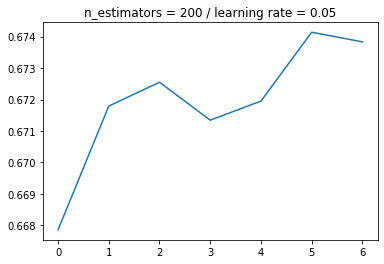

In [0]:
gbc, score = optimize2(n_estimators = n_estimators,
                       learning_rate = learning_rate,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       max_depth = max_depth,
                       max_features = max_features,
                       subsample = subsample)

In [0]:
score

0.6738332585225517

In [0]:
scores

array([0.66785681, 0.67179333, 0.67254987, 0.67134409, 0.67195088,
       0.67413867, 0.67383326])

In [0]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
scores = np.append(scores, score)

In [0]:
# MODELO 6
learning_rate /= 5
n_estimators *= 5
learning_rate, n_estimators

(0.01, 1000)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


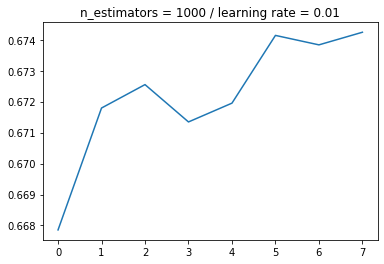

In [0]:
gbc, score = optimize2(n_estimators = n_estimators,
                       learning_rate = learning_rate,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       max_depth = max_depth,
                       max_features = max_features,
                       subsample = subsample)

In [0]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
scores = np.append(scores, score)

In [0]:
scores

array([0.66785681, 0.67179333, 0.67254987, 0.67134409, 0.67195088,
       0.67413867, 0.67383326, 0.67424078])

In [0]:
# MODELO 7
learning_rate /= 2
n_estimators *= 2
learning_rate, n_estimators

(0.005, 2000)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


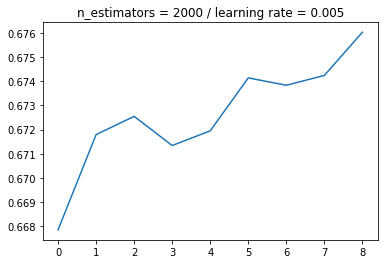

In [0]:
gbc, score = optimize2(n_estimators = n_estimators,
                       learning_rate = learning_rate,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       max_depth = max_depth,
                       max_features = max_features,
                       subsample = subsample)

In [0]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
scores = np.append(scores, score)

In [0]:
scores

array([0.66785681, 0.67179333, 0.67254987, 0.67134409, 0.67195088,
       0.67413867, 0.67383326, 0.67424078, 0.67602434])

In [0]:
# MODELO 8
learning_rate /= 5
n_estimators *= 5
learning_rate, n_estimators

(0.001, 10000)

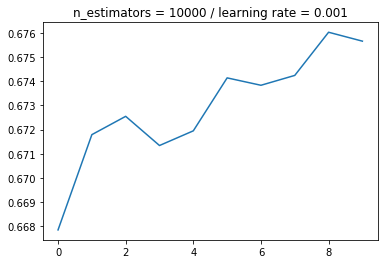

In [0]:
gbc, score = optimize2(n_estimators = n_estimators,
                       learning_rate = learning_rate,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf,
                       max_depth = max_depth,
                       max_features = max_features,
                       subsample = subsample)

In [0]:
# Atualizando as variáveis com os resultados
models = np.append(models, gbc)
scores = np.append(scores, score)

In [0]:
scores

array([0.66785681, 0.67179333, 0.67254987, 0.67134409, 0.67195088,
       0.67413867, 0.67383326, 0.67424078, 0.67602434, 0.67565592])

In [0]:
print('Modelo de melhor desempenho: ', scores.argmax(), ' - AUC: ', max(scores))

Modelo de melhor desempenho:  8  - AUC:  0.6760243412893268


In [0]:
best_model = models[scores.argmax()]

In [0]:
best_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.005, loss='deviance', max_depth=5,
                           max_features=29, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=50, min_samples_split=300,
                           min_weight_fraction_leaf=0.0, n_estimators=2000,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=0.9000000000000002,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
y_pred_probs = best_model.predict_proba(X_test)

In [0]:
y_pred_probs

array([[0.84254021, 0.15745979],
       [0.96644017, 0.03355983],
       [0.9460464 , 0.0539536 ],
       ...,
       [0.93890001, 0.06109999],
       [0.94081498, 0.05918502],
       [0.86984601, 0.13015399]])

In [0]:
y_pred_probs[:, 1]

array([0.15745979, 0.03355983, 0.0539536 , ..., 0.06109999, 0.05918502,
       0.13015399])

In [0]:
roc_auc_score(y_test, y_pred_probs[:, 1])

0.686824939672801

## Resultados KDD Cup 2009

https://www.kdd.org/kdd-cup/view/kdd-cup-2009/Results

## Conclusões

> Nesse exercício, foi possível modelar a possibilidade do cancelamento da conta com uma área sob a curva (AUC) de 0.6868

> É bom lembrar que AUC = 0.5 indica a linha de base, no caso de um modelo que faz predições aleatórias, e AUC = 1.0 indica um modelo ideal, que faz predições perfeitas

> Pode parecer que o AUC alcançado não é muito alto, mas também temos que considerar que o score mais alto no desafio público foi de 0.76

> Isso indica que, muito possivelmente, os dados fornecidos não são suficientes para fazer a modelagem perfeita do cancelamento da conta, e isso é sempre algo que devemos levar em consideração quando estamos tentando desenvolver modelos para problemas que não temos qualquer conhecimento prévio

> Fazendo uma analogia simples, seria como tentar predizer o peso de uma pessoa usando uma base de dados com apenas peso e altura de uma população: nós até conseguiríamos uma resposta razoável, já que as duas variáveis são correlacionadas, mas ela não seria perfeita simplesmente porque mais variáveis têm impacto no peso além da altura. É possível, portanto, que o maior score indique o melhor modelo que esses dados são capazes de fornecer

> Também devemos nos lembrar de que esses desafios geralmente são lançados sem que exista uma resposta prévia, eles servem justamente para que a própria comunidade tente encontrar soluções e comparar seus resultados entre si, e não com um "padrão ouro" ou a "resposta certa"

> Esses desafios são uma ótima oportunidade para se familiarizar com o ambiente real da carreira de um cientista de dados, e para conhecer e implementar na prática métodos e abordagens novas.

## Melhorias

> Testar outros modelos sempre é uma opção que se deve considerar. Nesse exercício, nós paramos nos classificadores do tipo gradient boosting, mas também poderíamos ter considerado modelos baseados em árvores de decisão mais novos, como o XGBoost, e até em redes neurais

> Os dados estão mascarados, o que dificulta qualquer feature engineering, já que para isso geralmente nós tentamos transformar as variáveis em função do conhecimento prévio que temos sobre elas. Por exemplo, se tivéssemos datas, poderíamos criar uma nova variável refletindo as estações do ano, se julgássemos relevante, mas nesse exercício ficamos restritos a tratar os dados com métricas estritamente numéricas, como o número de categorias que uma variável categórica possui, por não sabermos a que a variável se refere

> Mesmo com essas restrições, a seleção das melhores variáveis pode ser feita apenas considerando a natureza dos dados, e não da própria variável, e é possível testar outros métodos de seleção além daquele que nós usamos (seleção baseada em árvore de decisão)

> Também é possível melhorar o processo de fine-tuning da seguinte maneira: primeiro nós treinamos um hiperparâmetro num intervalo maior, por exemplo, [1, 2, 3, 4, 5], e depois que nós descobrimos o melhor parâmetro nessa faixa, por exemplo [2], podemos treinar de novo nas imediações desse valor, por exemplo [1.5, 2, 2.5], e assim por diante

> Ao final do treinamento apresentado no exercício (MODELO 8), nós observamos que a métrica continuava em tendência de aumentar, então talvez seja interessante continuar testando outros valores para learning rate/número de épocas

> Também é útil fazer um grid search com todos os parâmetros ao mesmo tempo, já que não necessariamente cada parâmetro se comporta da forma independente que nós consideramos, mas para isso é bom usar poucos valores para cada parâmetro (por isso é bom fazer uma seleção prévia da forma que nós fizemos), ou teríamos um número de modelos excessivamente grande pra testar, o que demanda maior capacidade de processamento

# Etapa 2: Modelando 'appetency' (tendência a usar novos produtos ou serviços)

O modelo para a nova variável de saída só precisa ser atualizado a partir da seleção de variáveis através de árvore de decisão. Primeiro carregaremos os dados correspondentes à variável `appetency`, depois presseguiremos com o pré-processamento do dataframe `features` até o final, repetindo o processo descrito acima.

In [0]:
outcome = pd.read_csv('orange_small_train_appetency.labels', header = None)

In [0]:
features_a = pd.get_dummies(features)

In [0]:
variables, importances = etc_importances(features_a, outcome)
sum_importances = sum_and_plot_importances(variables, importances)

In [0]:
features_a = keep_vars(features_a, sum_importances, threshold = 0.99)
features_a.shape

In [0]:
X_train, X_test, y_train, y_test = split_datasets(features_a, outcome)

In [0]:
rfc_test(X_train, y_train)

In [0]:
gbc_test(X_train, y_train)

In [0]:
models = np.array([])
opt_params = dict()
scores = np.array([])

In [0]:
### MODELO 0

learning_rate = 0.1
n_estimators = None
max_depth = 8
min_samples_split = 250
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'n_estimators': range(10, 101, 10)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
### MODELO 1

n_estimators = opt_params['n_estimators']
max_depth = None
min_samples_split = None
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'max_depth': range(1, 7, 1), 'min_samples_split': range(50, 151, 50)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
### MODELO 2

max_depth = opt_params['max_depth']
min_samples_split = opt_params['min_samples_split']
min_samples_leaf = None
max_features = 'sqrt'
subsample = 0.8
params = {'min_samples_leaf': range(1, 11, 1)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
### MODELO 3

min_samples_leaf = opt_params['min_samples_leaf']
max_features = None
subsample = 0.8
params = {'max_features': range(21, 31, 1)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
### MODELO 4

max_features =  opt_params['max_features']
subsample = None
params = {'subsample': np.append(np.arange(0.6, 1, 0.05), 1)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
learning_rate = 0.1
n_estimators = opt_params['n_estimators']

In [0]:
### MODELO 5

subsample = opt_params['subsample']
learning_rate /= 2
n_estimators *= 2

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [0]:
models = np.append(models, gbc);
scores = np.append(scores, score);

In [0]:
### MODELO 6

learning_rate /= 5
n_estimators *= 5

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [0]:
models = np.append(models, gbc);
scores = np.append(scores, score);

In [0]:
### MODELO 7

learning_rate /= 2
n_estimators *= 2

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [0]:
models = np.append(models, gbc);
scores = np.append(scores, score);

In [0]:
### MODELO 8

learning_rate /= 5
n_estimators *= 5

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [0]:
models = np.append(models, gbc);
scores = np.append(scores, score);

In [0]:
print('Modelo de melhor desempenho: ', scores.argmax(), ' - AUC: ', max(scores))

In [0]:
best_model = models[scores.argmax()]
best_model.fit(X_train, y_train)

In [0]:
y_pred_probs = best_model.predict_proba(X_test)
roc_auc_score(y_test, y_pred_probs[:, 1])

**Conclusão:** O modelo otimizado atingiu AUC de `0.7955` no dataset de teste.

# Etapa 3: Modelando 'upselling' (propensão para comprar upgrades)

In [0]:
outcome = pd.read_csv(path + 'orange_small_train_upselling.labels', header = None)

In [0]:
features_u = pd.get_dummies(features)

In [0]:
variables, importances = etc_importances(features_u, outcome)
sum_importances = sum_and_plot_importances(variables, importances)

In [0]:
features_u = keep_vars(features_u, sum_importances, threshold = 0.99)
features_u.shape

In [0]:
X_train, X_test, y_train, y_test = split_datasets(features_u, outcome)

In [0]:
rfc_test(X_train, y_train)

In [0]:
gbc_test(X_train, y_train)

In [0]:
models = np.array([])
opt_params = dict()
scores = np.array([])

In [0]:
### MODELO 0

learning_rate = 0.1
n_estimators = None
max_depth = 8
min_samples_split = 250
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'n_estimators': range(50, 101, 10)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
### MODELO 1

n_estimators = opt_params['n_estimators']
max_depth = None
min_samples_split = None
min_samples_leaf = 20
max_features = 'sqrt'
subsample = 0.8
params = {'max_depth': range(3, 12, 2), 'min_samples_split': range(150, 401, 50)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
### MODELO 2

max_depth = opt_params['max_depth']
min_samples_split = opt_params['min_samples_split']
min_samples_leaf = None
max_features = 'sqrt'
subsample = 0.8
params = {'min_samples_leaf': range(5, 50, 5)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
### MODELO 3

min_samples_leaf = opt_params['min_samples_leaf']
max_features = None
subsample = 0.8
params = {'max_features': range(20, 31, 1)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
### MODELO 4

max_features =  opt_params['max_features']
subsample = None
params = {'subsample': np.append(np.arange(0.6, 1, 0.05), 1)}

gbc, opt_param, score = optimize(n_estimators = n_estimators,
                                 learning_rate = learning_rate,
                                 min_samples_split = min_samples_split,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth,
                                 max_features = max_features,
                                 subsample = subsample,
                                 params = params)

In [0]:
models = np.append(models, gbc);
opt_params = {**opt_params, **opt_param}
scores = np.append(scores, score);

In [0]:
learning_rate = 0.1
n_estimators = opt_params['n_estimators']

In [0]:
### MODELO 5

subsample = opt_params['subsample']
learning_rate /= 2
n_estimators *= 2

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [0]:
models = np.append(models, gbc);
scores = np.append(scores, score);

In [0]:
### MODELO 6

learning_rate /= 5
n_estimators *= 5

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [0]:
models = np.append(models, gbc);
scores = np.append(scores, score);

In [0]:
### MODELO 7

learning_rate /= 2
n_estimators *= 2

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [0]:
models = np.append(models, gbc);
scores = np.append(scores, score);

In [0]:
### MODELO 8

learning_rate /= 5
n_estimators *= 5

gbc, score = optimize_2(n_estimators = n_estimators,
                        learning_rate = learning_rate,
                        min_samples_split = min_samples_split,
                        min_samples_leaf = min_samples_leaf,
                        max_depth = max_depth,
                        max_features = max_features,
                        subsample = subsample,
                        params = params)

In [0]:
models = np.append(models, gbc);
scores = np.append(scores, score);

In [0]:
print('Modelo de melhor desempenho: ', scores.argmax(), ' - AUC: ', max(scores))

In [0]:
best_model = models[scores.argmax()]
best_model.fit(X_train, y_train)

In [0]:
y_pred_probs = best_model.predict_proba(X_test)
roc_auc_score(y_test, y_pred_probs[:, 1])

**Conclusão:** O modelo otimizado atingiu AUC de `0.7622` no dataset de teste.